# Mutations

In [1]:
source(here::here("scripts/init.R"))

In [2]:
mut_df <- get_mut_df()
dim(mut_df)

[1] 283689      4

In [3]:
mut_df%>% distinct(samp) %>% nrow()

[1] 1659

We compare the distribution of the epigenomic scores with and without mutation for a panel of 171 genes. We do it separatly for activating (+) and inactivating (-) mutations. 

In [4]:
calc_features_mutation_pvals <- function(min_n = 10) {
    feats_tidy <- get_all_features() %>% 
        select(-caf, -immune) %>% 
        gather("feat", "score", -ER, -samp) 
    mut_df <- get_mut_df()
    df <- mut_df %>% left_join(feats_tidy, by = "samp")

    pvals_minus <- df %>%
        group_by(gene, ER, feat) %>%
        filter(sum(!is.na(score[mutation == "MUT-"])) >= min_n) %>%
        summarise(pval = wilcox.test(score[mutation == "MUT-"], score[mutation %in% c("NO MUT", "MUT+")])$p.value) %>%
        ungroup() %>%
        mutate(type = "MUT-")

    pvals_plus <- df %>%
        group_by(gene, ER, feat) %>%
        filter(sum(!is.na(score[mutation == "MUT+"])) >= min_n) %>%
        summarise(pval = wilcox.test(score[mutation == "MUT+"], score[mutation %in% c("NO MUT", "MUT-")])$p.value) %>%
        ungroup() %>%
        mutate(type = "MUT+")

    pvals <- bind_rows(pvals_minus, pvals_plus) %>%
        group_by(ER) %>% 
        mutate(qval = p.adjust(pval))    

    return(pvals)
} %cache_df% "data/features_mutations_pvals.tsv"

pvals <- calc_features_mutation_pvals()

In [5]:
signif_genes <- pvals %>%
        filter(qval <= 0.01) %>%
        pull(gene) %>%
        unique()

pvals %>% filter(qval <= 0.01) %>% arrange(gene) %>% mutate(signif = case_when(qval < 0.0001 ~ "****", qval < 0.001 ~ "***", qval < 0.01 ~ "**", qval < 0.05 ~ "*"))

gene,ER,feat,pval,type,qval,signif
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
CBFB,ER+,ML,1.859177e-06,MUT-,2.658623e-04,***
CDH1,ER+,MG,1.250775e-07,MUT-,1.801116e-05,****
GATA3,ER+,ML,3.488426e-05,MUT-,4.918680e-03,**
PIK3CA,ER-,MG,6.510399e-07,MUT+,1.302080e-05,****
TP53,ER+,immune.meth,4.098744e-06,MUT-,5.820217e-04,***
TP53,ER+,ML,4.633858e-20,MUT-,6.719094e-18,****


We plot the distribution of scores and mutations for the genes that were significant.

#### Figure 4B

Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


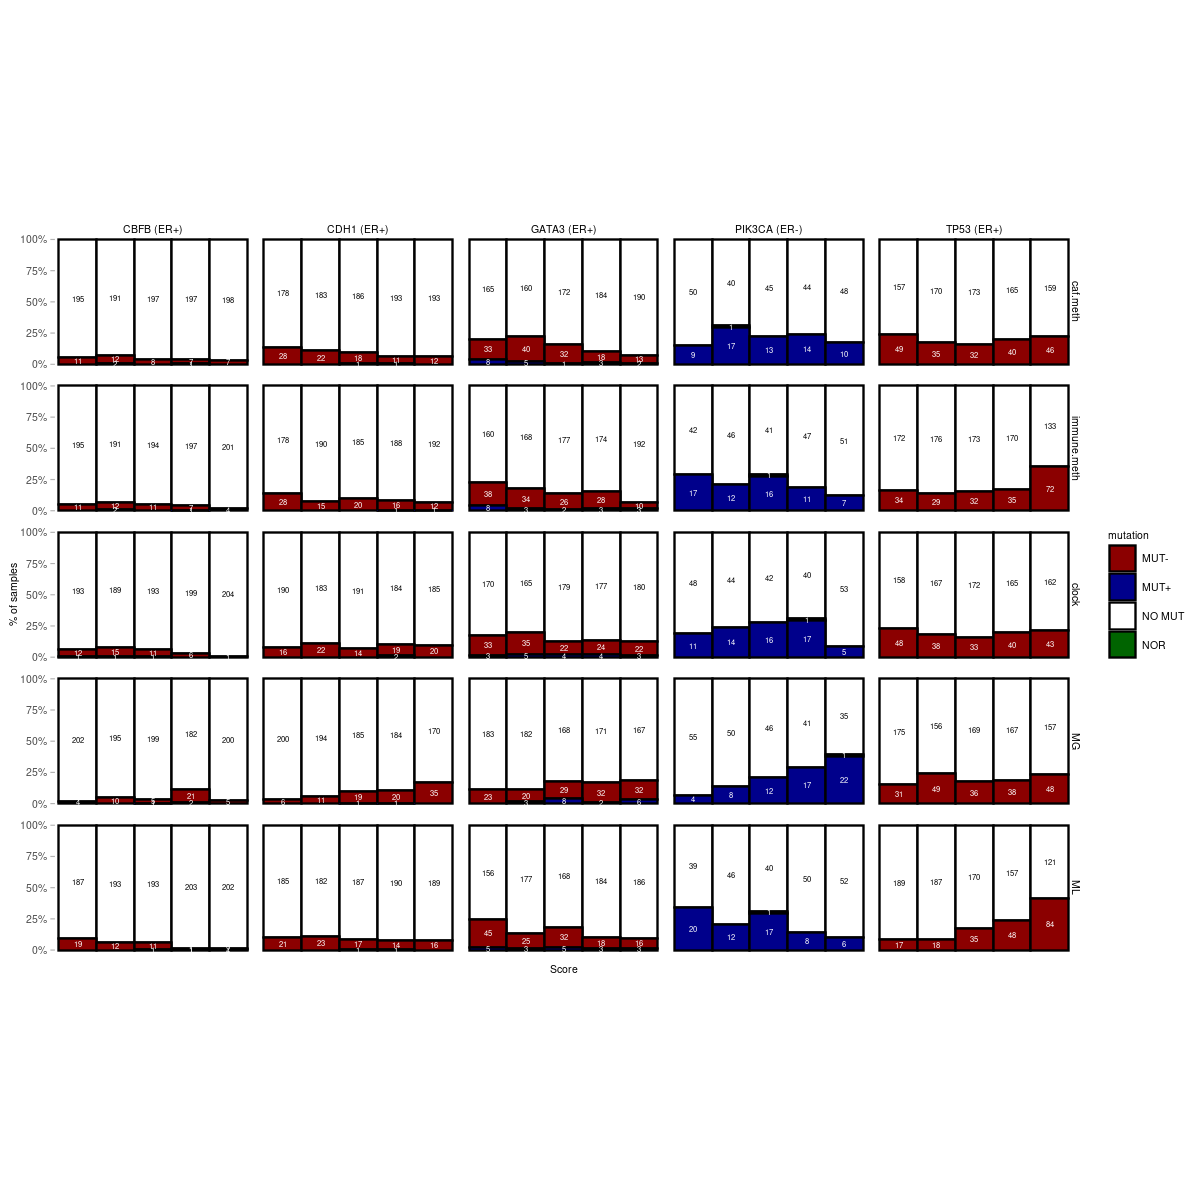

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
feats_tidy <- get_all_features() %>% 
        select(-caf, -immune) %>%         
        gather("feat", "score", -ER, -samp) 

mut_df_count <- get_mut_df() %>%
        left_join(feats_tidy) %>%
        mutate(mutation = factor(mutation, levels = c("NO MUT", "MUT-", "MUT+", "NOR"))) %>%
        filter(ER != "normal", mutation != "") %>%
        group_by(feat, ER) %>%
        mutate(score = cut(score, breaks = quantile(score, 0:5 / 5, na.rm = TRUE), include.lowest = TRUE, labels = as.character(1:5))) %>%
        count(gene, ER, feat, mutation, score) %>%
        group_by(gene, ER, feat, score) %>%
        mutate(p = n / sum(n)) %>%
        ungroup()

p <- mut_df_count %>%
    filter((gene == "PIK3CA" & ER == "ER-") | (gene != "PIK3CA" & ER == "ER+"), gene %in% signif_genes) %>%
    mutate(feat = factor(feat, c("caf.meth", "immune.meth", "clock", "MG", "ML"))) %>% 
    mutate(gene = paste0(gene, " (", ER, ")")) %>% 
    ggplot(aes(fill = mutation, y = p, x = score, color = mutation, label = n)) +
    geom_col(width = 1, color = "black") +
    scale_color_manual(values = c("MUT+" = "white", "MUT-" = "white", "NO MUT" = "black")) +
    scale_fill_manual(values = annot_colors$mutation) +
    geom_text(family = "Arial", size = 1.5, position = position_stack(vjust = 0.5)) +
    guides(color = "none") +
    facet_grid(feat ~ gene) +
    ylab("% of samples") +
    xlab("Score") +
    scale_y_continuous(labels = scales::percent) +
    theme(
        aspect.ratio = 0.7,
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_blank()
    )

p

We can test which associations hold even after adding PAM50 as a confounder:

In [7]:
calc_features_mutation_pvals_PAM50 <- function(min_n = 10) {
    feats_tidy <- get_all_features() %>% 
        select(-caf, -immune) %>% 
        gather("feat", "score", -ER, -samp) 
    mut_df <- get_mut_df()
    df <- mut_df %>% left_join(feats_tidy, by = "samp")
    
    df <- df %>% left_join(samp_data %>% select(samp, PAM50))

    pvals_minus <- df %>%
        group_by(gene, ER, PAM50, feat) %>%
        filter(sum(!is.na(score[mutation == "MUT-"])) >= min_n) %>%
        summarise(pval = wilcox.test(score[mutation == "MUT-"], score[mutation %in% c("NO MUT", "MUT+")])$p.value) %>%
        ungroup() %>%
        mutate(type = "MUT-")

    pvals_plus <- df %>%
        group_by(gene, ER, PAM50, feat) %>%
        filter(sum(!is.na(score[mutation == "MUT+"])) >= min_n) %>%
        summarise(pval = wilcox.test(score[mutation == "MUT+"], score[mutation %in% c("NO MUT", "MUT-")])$p.value) %>%
        ungroup() %>%
        mutate(type = "MUT+")

    pvals <- bind_rows(pvals_minus, pvals_plus) %>%
        group_by(ER, PAM50) %>% 
        mutate(qval = p.adjust(pval))    

    return(pvals)
} %cache_df% "data/features_mutations_pvals_PAM50.tsv"

pvals_pam50 <- calc_features_mutation_pvals_PAM50()

Joining, by = "samp"



In [8]:
signif_genes_pam50 <- pvals_pam50 %>%
        filter(qval <= 0.01) %>%
        pull(gene) %>%
        unique()

pvals_pam50 %>% filter(qval <= 0.01) %>% arrange(gene)

gene,ER,PAM50,feat,pval,type,qval
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
CDH1,ER+,LUMA,MG,0.0000063740045,MUT-,0.00050354636
GATA3,ER+,LUMA,ML,0.0000465714399,MUT-,0.00363257231
PIK3CA,ER+,LUMA,ML,0.0000004288503,MUT+,0.00003430802
TP53,ER+,LUMA,ML,0.0000823223268,MUT-,0.00633881916
TP53,ER+,LUMB,ML,0.0000016139331,MUT-,0.00008069666


In [ ]:
gc()